# Text-to-SQL Chain
### DB: AWS S3
### SQL: AWS Athena
### Chat History Storage: AWS DynamoDB
### LLM: GPT-3.5

## Chain: User Input -> Text2SQL Prompt -> Agent with tools -> LLM -> SQL Query -> DB -> Query Result -> LLM -> Natural Language Response

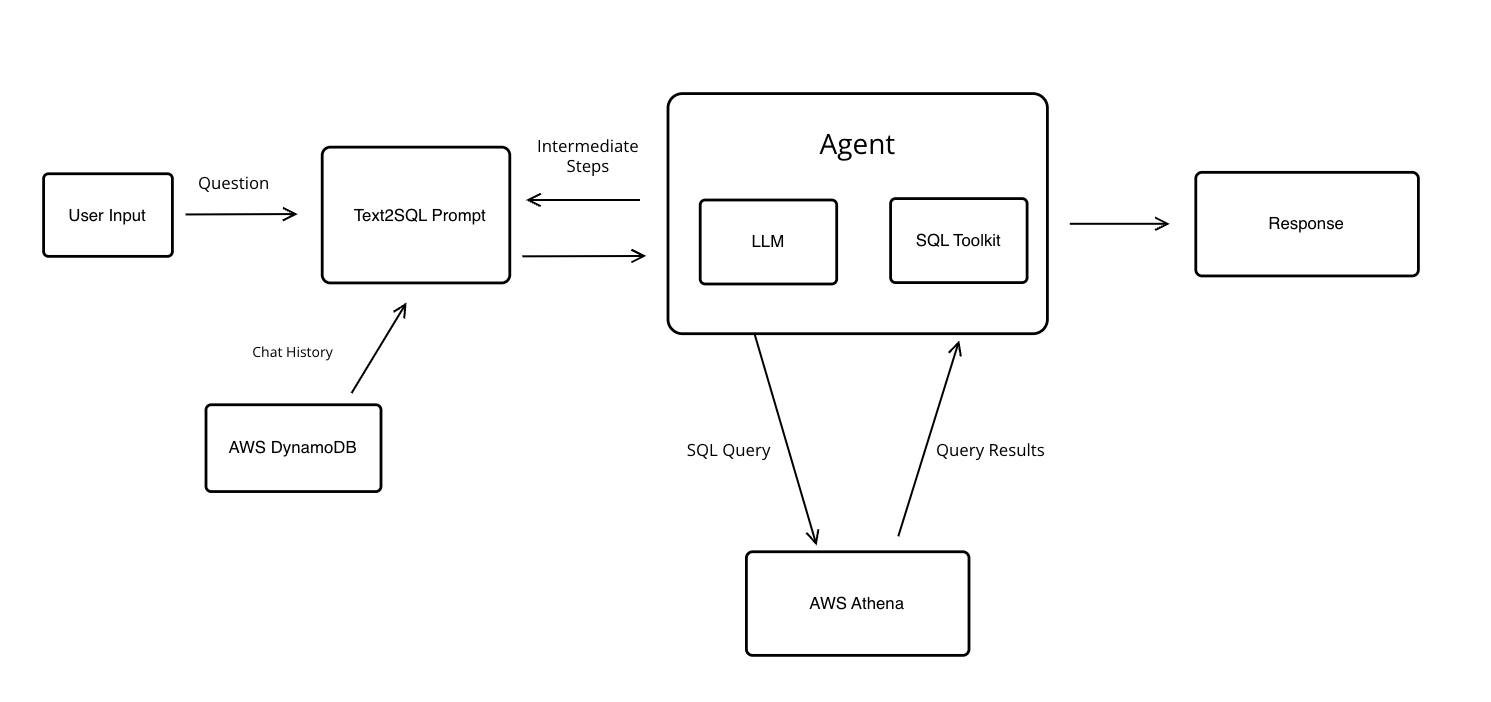

In [1]:
import getpass
import os

#set environmental variable for OpenAI API key
os.environ["OPENAI_API_KEY"] = getpass.getpass()

 ········


#### set up AWS DynamoDB for Chat History

In [2]:
import boto3
from langchain_community.chat_message_histories import (
    DynamoDBChatMessageHistory,
)

#set up dynamodb
dynamodb = boto3.resource("dynamodb")

#create composite key (session id & user id) for accessing databases
composite_key = {
    "SessionId": "session_id::12",
    "UserID": "0001",
}

#query DynamoDB for chat history using the composite key
chat_history = DynamoDBChatMessageHistory(
    table_name = "Chat_Table",
    session_id = "0",
    key = composite_key,
    history_size = 6,
)

#### set up AWS S3 and Athena for Database Access

In [3]:
from sqlalchemy import create_engine
from urllib.parse import quote_plus
from langchain_community.utilities import SQLDatabase

#database info
AWS_REGION = "us-east-1"
SCHEMA_NAME = "wnba_db"
S3_STAGING_DIR = "s3://wnbadata/"

connect_str = "awsathena+rest://athena.{region_name}.amazonaws.com:443/{schema_name}?s3_staging_dir={s3_staging_dir}"

#connect to AWS athena
engine = create_engine(connect_str.format(
        region_name=AWS_REGION,
        schema_name=SCHEMA_NAME,
        s3_staging_dir=quote_plus(S3_STAGING_DIR)
))

#create SQL db object
db = SQLDatabase(engine)

#fetch table schema
schema = db.get_table_info()

/var/folders/1c/ybx_8cds1ybgdg3z19ptmmk00000gn/T/ipykernel_67823/3266133602.py:13: SADeprecationWarning: The dbapi() classmethod on dialect classes has been renamed to import_dbapi().  Implement an import_dbapi() classmethod directly on class <class 'pyathena.sqlalchemy.rest.AthenaRestDialect'> to remove this warning; the old .dbapi() classmethod may be maintained for backwards compatibility.
  engine = create_engine(connect_str.format(


#### set up LLM, tools, agent, and prompt

In [4]:
from langchain.globals import set_debug
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.prompts import MessagesPlaceholder
from langchain.agents.format_scratchpad.openai_tools import (
    format_to_openai_tool_messages,
)
from langchain.agents.output_parsers.openai_tools import OpenAIToolsAgentOutputParser
from langchain.agents import tool
from langchain.agents import AgentExecutor
from langchain_community.agent_toolkits import SQLDatabaseToolkit

#set up LLM
llm = ChatOpenAI(model_name= "gpt-3.5-turbo-0125", temperature= 0)

#utilize langchain agent toolkit: SQL toolkit
toolkit = SQLDatabaseToolkit(db=db, llm=llm)
tools = toolkit.get_tools()
llm_with_tools = llm.bind_tools(tools)

#create prompt for agent
prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        """You are an agent designed to interact with a SQL database to answer questions about the WNBA.
        Given an input question, create a syntactically correct SQLite query to run, then look at the results of the query and return the answer.
        You should also leverage your pre-existing knowledge of WNBA rules, statistics, teams, players, and history to understand and interpret user questions and your answer accurately.
        Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
        You can order the results by a relevant column to return the most interesting examples in the database.
        Never query for all the columns from a specific table, only ask for the relevant columns given the question.
        You have access to tools for interacting with the database.
        Only use the below tools. Only use the information returned by the below tools to construct your final answer.
        Base your final answer solely on the information returned by these tools, combined with your existing knowledge of the WNBA.
        You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.
        
        DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.
        
        To start you should ALWAYS look at the tables in the database to see what you can query.
        Do NOT skip this step.
        Then you should query the schema of the most relevant tables.""",
    ),
    #message placeholder for chat history
    MessagesPlaceholder(variable_name="chat_history"),
    ("user", "{input}"),
    #message placeholder for storing intermediate steps
    MessagesPlaceholder(variable_name="agent_scratchpad"),
])

#create agent
agent = (
    {
        "input": lambda x: x["input"],
        "agent_scratchpad": lambda x: format_to_openai_tool_messages(
            x["intermediate_steps"]
        ),
        "chat_history": lambda x: x["chat_history"],
    }
    | prompt
    | llm_with_tools
    | OpenAIToolsAgentOutputParser()
)
agent_executor = AgentExecutor(agent = agent, tools = tools, verbose = False, return_intermediate_steps = True)

#### execution of text2sql chain

In [5]:
from langchain_core.messages import AIMessage, HumanMessage

input_text = input('>>> ')
while input_text.lower() != 'bye':
    if input_text:
        
        print("loading response....")
        
        response = agent_executor.invoke({
            'input': input_text,
            'chat_history': chat_history.messages,
        })
        chat_history.add_user_message(input_text)
        chat_history.add_ai_message(response["output"])

        print("Response: " + response['output'])
    input_text = input('>>> ')

>>>  Which player scored the most points in a single game between 2018 and 2024?


loading response....
Response: The player who scored the most points in a single game between 2018 and 2024 was Liz Cambage, who scored 53 points in a game.


>>>  Which team had the highest average points per game in the 2021 season?


loading response....
Response: The team with the highest average points per game in the 2021 season was "Team WNBA" with an average of 93 points per game.


>>>  How many games ended in overtime during the 2023 season?


loading response....
Response: I apologize for the inconvenience, but it seems that the necessary tables for retrieving information about overtime games in the 2023 season are not available in the database. If you have any other questions or queries, feel free to ask.


>>>  Which player had the highest free throw percentage in the 2020 season?


loading response....
Response: I apologize for the inconvenience, but it seems that the table "PlayerStats" is not available in the database to retrieve information about free throw percentages for players in the 2020 season. If you have any other questions or queries, feel free to ask.


>>>  What was the win-loss record of the Seattle Storm in the 2022 season?


loading response....
Response: I apologize for the inconvenience, but it seems that the necessary table "Teams" is not available in the database to retrieve the win-loss record of the Seattle Storm in the 2022 season. If you have any other questions or queries, feel free to ask.


>>>  Which team had the longest winning streak in the 2019 season?


loading response....
Response: I apologize for the inconvenience, but it seems that the necessary table "Teams" is not available in the database to retrieve information about the longest winning streak of a team in the 2019 season. If you have any other questions or queries, feel free to ask.


>>>  How many triple-doubles were recorded in the WNBA between 2018 and 2024, and by which players?


loading response....
Response: I apologize for the inconvenience, but it seems that the table "PlayerStats" is not available in the database to retrieve information about triple-doubles recorded by players in the WNBA between 2018 and 2024. If you have any other questions or queries, feel free to ask.


>>>  Which team had the best defense in the 2024 season (by opponent points)?


loading response....
Response: I apologize for the inconvenience, but it seems that the necessary table "TeamSeasonStats" is not available in the database to retrieve information about the team with the best defense in terms of opponent points in the 2024 season. If you have any other questions or queries, feel free to ask.


>>>  Identify the game with the highest combined score (both teams) from 2018 to 2024.


loading response....
Response: I apologize for the inconvenience, but it seems that the necessary table "Games" is not available in the database to retrieve information about the game with the highest combined score from 2018 to 2024. If you have any other questions or queries, feel free to ask.


>>>  Which player played the most minutes in the 2021 season?


loading response....
Response: I apologize for the inconvenience, but it seems that the table "PlayerGameStats" is not available in the database to retrieve information about the player who played the most minutes in the 2021 season. If you have any other questions or queries, feel free to ask.


>>>  bye
